In [19]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [20]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
# Parâmetro do ruído
noise_factor = 0.05

# Função para adicionar diferentes tipos de ruído
def add_noise(y, sr, noise_factor=noise_factor, noise_type="white"):
    if noise_type == "white":
        noise = np.random.randn(len(y))  # Ruído branco
    elif noise_type == "pink":
        noise = np.cumsum(np.random.randn(len(y)))  # Ruído rosa
        noise = noise / max(abs(noise))  # Normalizar o ruído rosa
    elif noise_type == "background":
        try:
            bg_noise, _ = librosa.load("background_noise.wav", sr=sr)  # Ruído real
            noise = np.interp(np.linspace(0, len(bg_noise), len(y)), np.arange(len(bg_noise)), bg_noise)
        except Exception as e:
            print(f"Erro ao carregar ruído de fundo: {e}")
            noise = np.random.randn(len(y))  # Se falhar, usa ruído branco
    else:
        raise ValueError("Tipo de ruído inválido. Escolha entre 'white', 'pink' ou 'background'.")

    y_noise = y + noise_factor * noise
    return np.clip(y_noise, -1.0, 1.0)  # Normaliza o áudio para evitar distorção

# Função para extrair MFCCs do áudio
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Retorna a média dos coeficientes
    except Exception as e:
        print(f"Erro ao extrair MFCCs: {e}")
        return None

# Função para carregar dados e aplicar ruído
def load_data_with_noise(folder_path, label, noise_type="white"):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)
            if features is not None:
                data.append(features)
                labels.append(label)

            # Adicionar ruído e extrair features novamente
            y_noise = add_noise(y, sr, noise_type=noise_type)
            features_noise = extract_features(y_noise, sr)

            if features_noise is not None:
                data.append(features_noise)
                labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

    return data, labels

In [22]:
# Definir caminhos dos áudios
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

# Criar diretórios se não existirem
os.makedirs(file_path_real, exist_ok=True)
os.makedirs(file_path_fake, exist_ok=True)

# Carregar dados com ruído
data_real, labels_real = load_data_with_noise(file_path_real, label=1, noise_type="pink")  # Áudios reais
data_fake, labels_fake = load_data_with_noise(file_path_fake, label=0, noise_type="white")  # Áudios falsos

# Unir dados reais e falsos
data = data_real + data_fake
labels = labels_real + labels_fake

# Remover valores None
data_filtered, labels_filtered = zip(*[(d, l) for d, l in zip(data, labels) if d is not None])

In [23]:
# Função para plotar a comparação com as formas de onda em preto
def plot_audio_comparison(folder_path, noise_type="background", noise_factor=0.05):

    # Usa o estilo padrão com fundo branco
    plt.style.use('default')

    # Pega o primeiro arquivo da pasta
    first_audio_file = os.listdir(folder_path)[0]
    audio_path = os.path.join(folder_path, first_audio_file)

    # Carrega o áudio
    y, sr = librosa.load(audio_path, sr=None)

    # Aplica o ruído
    y_noise = add_noise(y, sr, noise_factor=noise_factor, noise_type=noise_type)

    # Cor preta mais clara
    wave_color = "#333333"  # Cinza escuro

    # Plota o original e com ruído
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.title("Áudio Original", fontsize=14)
    librosa.display.waveshow(y, sr=sr, color=wave_color)  # linha preta
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.title(f"Áudio com Ruído", fontsize=14)
    librosa.display.waveshow(y_noise, sr=sr, color=wave_color)  # linha preta
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro ao carregar ruído de fundo: [Errno 2] No such file or directory: 'background_noise.wav'


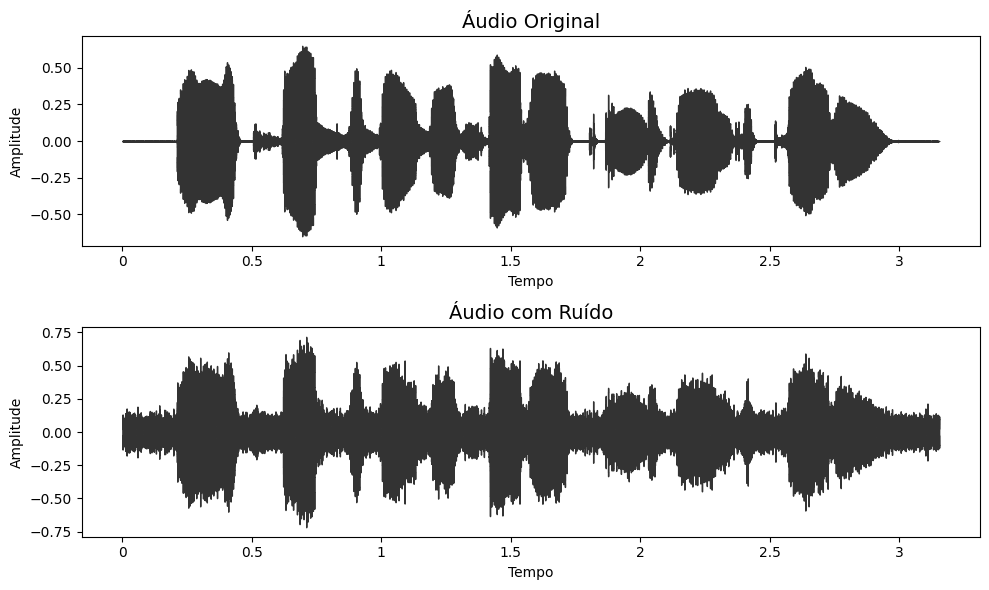

In [24]:
plot_audio_comparison('/content/drive/MyDrive/audios_FOR/real', noise_factor=0.05)

In [25]:
#np.random.seed(None)  # Remove o seed fixo
#np.random.shuffle(labels)  # Bagunça os rótulos de maneira mais imprevisível

In [26]:
# Criar DataFrame
df = pd.DataFrame(data_filtered)
df['label'] = labels_filtered

In [28]:
df.shape

(1440, 14)

In [29]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

In [30]:
# Função para calcular e exibir as métricas
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\n")

In [40]:
# Dividir em treino e teste
X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(X, y, test_size=0.2, random_state=1)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=1, max_features=1)
rf_model.fit(X_train_rf_model, y_train_rf_model)
rf_pred = rf_model.predict(X_test_rf_model)
print("Random Forest:")
print_metrics(y_test_rf_model, rf_pred)

Random Forest:
Acurácia: 0.87
Precisão: 0.94
Recall: 0.88
F1-Score: 0.91




In [51]:
# Dividir em treino e teste
X_train_lgb_model, X_test_lgb_model, y_train_lgb_model, y_test_lgb_model = train_test_split(X, y, test_size=0.2, random_state=2)

# 2. LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1, n_estimators=1)
lgb_model.fit(X_train_lgb_model, y_train_lgb_model)
lgb_pred = lgb_model.predict(X_test_lgb_model)
print("LightGBM:")
print_metrics(y_test_lgb_model, lgb_pred)

LightGBM:
Acurácia: 0.72
Precisão: 0.72
Recall: 1.00
F1-Score: 0.83




In [48]:
# Dividir em treino e teste
X_train_nb_model, X_test_nb_model, y_train_nb_model, y_test_nb_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 3. Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb_model, y_train_nb_model)
nb_pred = nb_model.predict(X_test_nb_model)
print("Naïve Bayes:")
print_metrics(y_test_nb_model, nb_pred)

Naïve Bayes:
Acurácia: 0.89
Precisão: 0.89
Recall: 0.95
F1-Score: 0.92




In [34]:
# Dividir em treino e teste
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=4)

# Padronização dos dados para LSTM e KNN
scaler = StandardScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_lstm)
X_test_scaled_lstm = scaler.transform(X_test_lstm)

# 4. LSTM
X_train_lstm = X_train_scaled_lstm.reshape(-1, 1, X_train_scaled_lstm.shape[1])
X_test_lstm = X_test_scaled_lstm.reshape(-1, 1, X_test_scaled_lstm.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(units=1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, verbose=0)
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int64")
print("LSTM:")
print_metrics(y_test_lstm, lstm_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
LSTM:
Acurácia: 0.32
Precisão: 0.53
Recall: 0.39
F1-Score: 0.45




In [42]:
# Dividir em treino e teste
X_train_knn_model, X_test_knn_model, y_train_knn_model, y_test_knn_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 5. KNN
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_knn_model, y_train_knn_model)
knn_pred = knn_model.predict(X_test_knn_model)
print("KNN:")
print_metrics(y_test_knn_model, knn_pred)

KNN:
Acurácia: 0.89
Precisão: 0.86
Recall: 1.00
F1-Score: 0.93


